I noticed my model predicting almost same values over date_id (with low std) without changing ranks for each targets, still scoreing 0.2~0.3.  
So I experimented simple rulebase prediction by rank moving average of historical target values. Public score (90 days score) was 0.25.  
This indicates some models with score around 0.2 can be attributed to just average prediction contribution.  

```
# (RankIC Sharpe, RankIC mean, RankIC std)
public LB score (first 90 days only) :  (0.2543529319372721, 0.06189327032840158, 0.24333617803024005)
first 90 days + extended data score :  (0.22304106140992572, 0.050887127273631746, 0.22815138590157005)
extended data only score :  (0.14820661047865658, 0.028374561934329797, 0.19145274183580396)
```

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

## Config

In [2]:
MA_LOOKBACK_WINDOW = 2 * 252

## Data Preparation

In [3]:
df_train = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train.csv').set_index('date_id')
# df_test = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/test.csv')
df_target_pairs = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/target_pairs.csv')
df_train_labels = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train_labels.csv').set_index('date_id')

df_train_labels_shift2 = df_train_labels.copy().shift(2)  # for label_lags_1_batch
df_train_labels_shift3 = df_train_labels.copy().shift(3)  # for label_lags_2_batch
df_train_labels_shift4 = df_train_labels.copy().shift(4)  # for label_lags_3_batch
df_train_labels_shift5 = df_train_labels.copy().shift(5)  # for label_lags_4_batch

LAG1_TARGETS = df_target_pairs[df_target_pairs['lag'] == 1]['target'].tolist()
LAG2_TARGETS = df_target_pairs[df_target_pairs['lag'] == 2]['target'].tolist()
LAG3_TARGETS = df_target_pairs[df_target_pairs['lag'] == 3]['target'].tolist()
LAG4_TARGETS = df_target_pairs[df_target_pairs['lag'] == 4]['target'].tolist()
print(len(LAG1_TARGETS), len(LAG2_TARGETS), len(LAG3_TARGETS), len(LAG4_TARGETS))

106 106 106 106


In [4]:
df_train

,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,JPX_RSS3_Rubber_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
date_id,,,,,,,,,,,,,,,,,,,,,
0,2264.5,7205.0,2570.0,3349.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.699987,0.776874,0.888115,0.689954,0.066653,0.090582,0.119630,0.078135,13.822740,0.059163
1,2228.0,7147.0,2579.0,3327.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.695279,0.778682,0.889488,0.692628,0.067354,0.091297,0.120520,0.079066,13.888146,0.059895
2,2250.0,7188.5,2587.0,3362.0,4684.0,4691.0,4684.0,3363.0,3367.0,207.0,...,1.692724,0.780186,0.894004,0.697490,0.067394,0.091478,0.120809,0.079287,13.983675,0.060037
3,2202.5,7121.0,2540.0,3354.0,4728.0,4737.0,4729.0,3430.0,3426.0,207.0,...,1.683111,0.785329,0.889439,0.698502,0.067639,0.091558,0.121021,0.079285,14.035571,0.059983
4,2175.0,7125.0,2604.0,3386.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.684816,0.787264,0.891042,0.701485,0.067443,0.091266,0.121055,0.078925,14.013760,0.059503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,2629.5,9778.5,2010.0,2818.5,16041.0,16183.0,16046.0,6076.0,6073.0,325.4,...,1.842075,0.584336,0.819066,0.478610,0.048581,0.073181,0.078771,0.045312,14.606239,0.042097
1957,2646.5,9860.0,2014.5,2838.5,NaN,NaN,NaN,NaN,NaN,NaN,...,1.844791,0.583610,0.816264,0.476380,0.048547,0.072941,0.078532,0.045315,14.502889,0.042089
1958,2658.5,9919.5,2011.0,2860.0,16132.5,16261.0,16134.0,6200.0,6200.0,330.0,...,1.839538,0.583402,0.816093,0.476110,0.048495,0.073421,0.078794,0.045184,14.580416,0.042103


## Submit

In [5]:
import os

import pandas as pd
import polars as pl

import kaggle_evaluation.mitsui_inference_server


NUM_TARGET_COLUMNS = 424


def predict(
    test: pl.DataFrame,
    label_lags_1_batch: pl.DataFrame,
    label_lags_2_batch: pl.DataFrame,
    label_lags_3_batch: pl.DataFrame,
    label_lags_4_batch: pl.DataFrame,
) -> pl.DataFrame | pd.DataFrame:
    """Replace this function with your inference code.
    You can return either a Pandas or Polars dataframe, though Polars is recommended for performance.
    Each batch of predictions (except the very first) must be returned within 1 minute of the batch features being provided.
    """
    target_date_id = test.to_pandas().iloc[-1]['date_id']
    print(datetime.now(), target_date_id, df_train.index.max() - target_date_id)

    if len(test) > 0:
        g_test_history.append(test.to_pandas())
    if len(label_lags_1_batch) > 0:
        g_label_lags_1_batch_history.append(label_lags_1_batch.to_pandas())
    if len(label_lags_2_batch) > 0:
        g_label_lags_2_batch_history.append(label_lags_2_batch.to_pandas())
    if len(label_lags_3_batch) > 0:
        g_label_lags_3_batch_history.append(label_lags_3_batch.to_pandas())
    if len(label_lags_4_batch) > 0:
        g_label_lags_4_batch_history.append(label_lags_4_batch.to_pandas())

    if len(g_label_lags_1_batch_history) > 0:
        df_labels_lag1 = pd.concat(g_label_lags_1_batch_history).set_index('date_id')
        df_labels_lag1 = pd.concat([
            df_train_labels_shift2.loc[df_train_labels_shift2.index < df_labels_lag1.index.min(), LAG1_TARGETS].sort_index().iloc[-MA_LOOKBACK_WINDOW:],
            df_labels_lag1
        ]).sort_index()
    else:
        df_labels_lag1 = df_train_labels_shift2.loc[df_train_labels_shift2.index < target_date_id, LAG1_TARGETS].sort_index().iloc[-MA_LOOKBACK_WINDOW:]

    if len(g_label_lags_2_batch_history) > 0:
        df_labels_lag2 = pd.concat(g_label_lags_2_batch_history).set_index('date_id') if len(g_label_lags_2_batch_history) > 0 else pd.DataFrame()
        df_labels_lag2 = pd.concat([
            df_train_labels_shift3.loc[df_train_labels_shift3.index < df_labels_lag2.index.min(), LAG2_TARGETS].sort_index().iloc[-MA_LOOKBACK_WINDOW:],
            df_labels_lag2
        ]).sort_index()
    else:
        df_labels_lag2 = df_train_labels_shift3.loc[df_train_labels_shift3.index < target_date_id, LAG2_TARGETS].sort_index().iloc[-MA_LOOKBACK_WINDOW:]

    if len(g_label_lags_3_batch_history) > 0:
        df_labels_lag3 = pd.concat(g_label_lags_3_batch_history).set_index('date_id') if len(g_label_lags_3_batch_history) > 0 else pd.DataFrame()
        df_labels_lag3 = pd.concat([
            df_train_labels_shift4.loc[df_train_labels_shift4.index < df_labels_lag3.index.min(), LAG3_TARGETS].sort_index().iloc[-MA_LOOKBACK_WINDOW:],
            df_labels_lag3
        ]).sort_index()
    else:
        df_labels_lag3 = df_train_labels_shift4.loc[df_train_labels_shift4.index < target_date_id, LAG3_TARGETS].sort_index().iloc[-MA_LOOKBACK_WINDOW:]

    if len(g_label_lags_4_batch_history) > 0:
        df_labels_lag4 = pd.concat(g_label_lags_4_batch_history).set_index('date_id') if len(g_label_lags_4_batch_history) > 0 else pd.DataFrame()
        df_labels_lag4 = pd.concat([
            df_train_labels_shift5.loc[df_train_labels_shift5.index < df_labels_lag4.index.min(), LAG4_TARGETS].sort_index().iloc[-MA_LOOKBACK_WINDOW:],
            df_labels_lag4
        ]).sort_index()
    else:
        df_labels_lag4 = df_train_labels_shift5.loc[df_train_labels_shift5.index < target_date_id, LAG4_TARGETS].sort_index().iloc[-MA_LOOKBACK_WINDOW:]

    TARGET_COLS = [f'target_{i}' for i in range(NUM_TARGET_COLUMNS)]

    df_labels = pd.concat([df_labels_lag1, df_labels_lag2, df_labels_lag3, df_labels_lag4], axis=1)[TARGET_COLS].sort_index()
    df_labels_rank = df_labels.rank(pct=True, axis=1)
    predictions = df_labels_rank.iloc[-MA_LOOKBACK_WINDOW:].mean().to_frame().T

    g_df_pred_dict[test.to_pandas().iloc[-1]['date_id']] = predictions

    assert isinstance(predictions, (pd.DataFrame, pl.DataFrame))
    assert len(predictions) == 1
    return predictions


In [6]:
g_test_history = []
g_label_lags_1_batch_history = []
g_label_lags_2_batch_history = []
g_label_lags_3_batch_history = []
g_label_lags_4_batch_history = []
g_df_pred_dict = {}

# When your notebook is run on the hidden test set, inference_server.serve must be called within 15 minutes of the notebook starting
# or the gateway will throw an error. If you need more than 15 minutes to load your model you can do so during the very
# first `predict` call, which does not have the usual 1 minute response deadline.
inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

2025-09-11 07:10:34.069989 1827 133
2025-09-11 07:10:34.463278 1828 132
2025-09-11 07:10:34.729286 1829 131
2025-09-11 07:10:34.999079 1830 130
2025-09-11 07:10:35.278144 1831 129
2025-09-11 07:10:35.555703 1832 128
2025-09-11 07:10:35.945707 1833 127
2025-09-11 07:10:36.240511 1834 126
2025-09-11 07:10:36.524921 1835 125
2025-09-11 07:10:36.805184 1836 124
2025-09-11 07:10:37.106389 1837 123
2025-09-11 07:10:37.415193 1838 122
2025-09-11 07:10:37.701524 1839 121
2025-09-11 07:10:37.991706 1840 120
2025-09-11 07:10:38.281697 1841 119
2025-09-11 07:10:38.566504 1842 118
2025-09-11 07:10:38.861036 1843 117
2025-09-11 07:10:39.264063 1844 116
2025-09-11 07:10:39.558217 1845 115
2025-09-11 07:10:39.848739 1846 114
2025-09-11 07:10:40.143108 1847 113
2025-09-11 07:10:40.437877 1848 112
2025-09-11 07:10:40.737251 1849 111
2025-09-11 07:10:41.032591 1850 110
2025-09-11 07:10:41.325880 1851 109
2025-09-11 07:10:41.625208 1852 108
2025-09-11 07:10:41.921544 1853 107
2025-09-11 07:10:42.220160 1

## Evaluation

In [7]:
_dateids, _dfs = zip(*list(g_df_pred_dict.items()))
_df_pred = pd.concat(_dfs)
_df_pred.index = _dateids
_df_pred.index.name = 'date_id'

In [8]:
_df_pred

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
date_id,,,,,,,,,,,,,,,,,,,,,
1827,0.520489,0.483951,0.507919,0.508673,0.487900,0.500658,0.505084,0.486538,0.496043,0.508114,...,0.566141,0.486823,0.473499,0.519959,0.505258,0.498829,0.530245,0.548921,0.531255,0.462915
1828,0.521144,0.482865,0.507192,0.509099,0.488985,0.501662,0.503590,0.486756,0.495984,0.508770,...,0.566294,0.487199,0.473282,0.520330,0.503435,0.497017,0.531262,0.547788,0.531135,0.461076
1829,0.521442,0.482924,0.507073,0.507972,0.488132,0.501227,0.504497,0.487321,0.495755,0.508597,...,0.565943,0.487550,0.472932,0.520700,0.500671,0.494183,0.532101,0.546019,0.531945,0.462920
1830,0.521006,0.482726,0.507248,0.508887,0.488148,0.499711,0.503856,0.486890,0.494897,0.508468,...,0.565809,0.486688,0.472241,0.520442,0.499084,0.492455,0.531772,0.545599,0.532619,0.462783
1831,0.521378,0.482270,0.507737,0.509418,0.487660,0.499914,0.503673,0.486091,0.494890,0.508456,...,0.566094,0.486574,0.470888,0.520977,0.497960,0.491800,0.532531,0.545513,0.533877,0.462752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,0.522243,0.484857,0.505564,0.505183,0.489228,0.495952,0.502221,0.490843,0.499564,0.507030,...,0.565386,0.492871,0.459153,0.541289,0.492962,0.496265,0.532967,0.544894,0.543553,0.459235
1957,0.522475,0.484488,0.505716,0.505627,0.489264,0.494983,0.501864,0.490482,0.499233,0.506594,...,0.566389,0.492155,0.459863,0.542319,0.491687,0.494984,0.532893,0.543744,0.544556,0.460445
1958,0.522500,0.484093,0.505186,0.504852,0.488859,0.495076,0.501573,0.491097,0.499088,0.506718,...,0.565873,0.492279,0.460602,0.543592,0.490076,0.494354,0.532175,0.542742,0.545318,0.461831


Text(0, 0.5, 'rank')

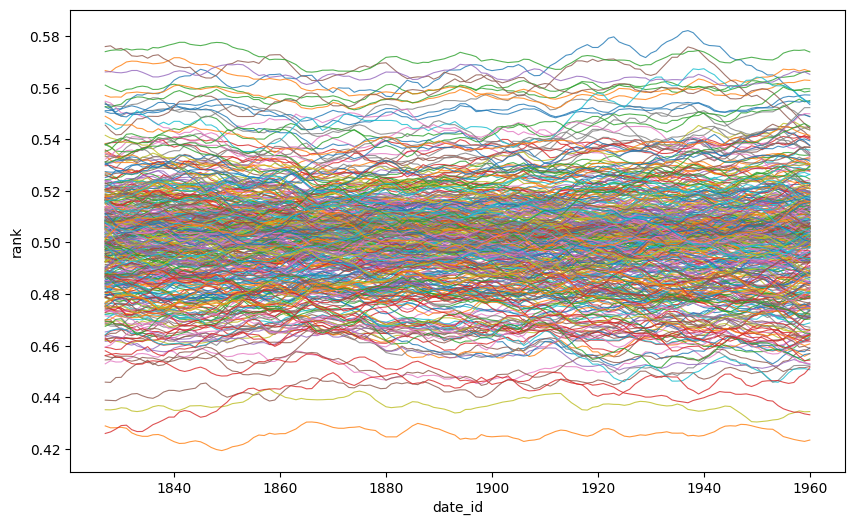

In [9]:
_df_pred.plot(legend=False, figsize=(10, 6), linewidth=0.8, alpha=0.8)
plt.ylabel('rank')

Text(0, 0.5, 'average rank')

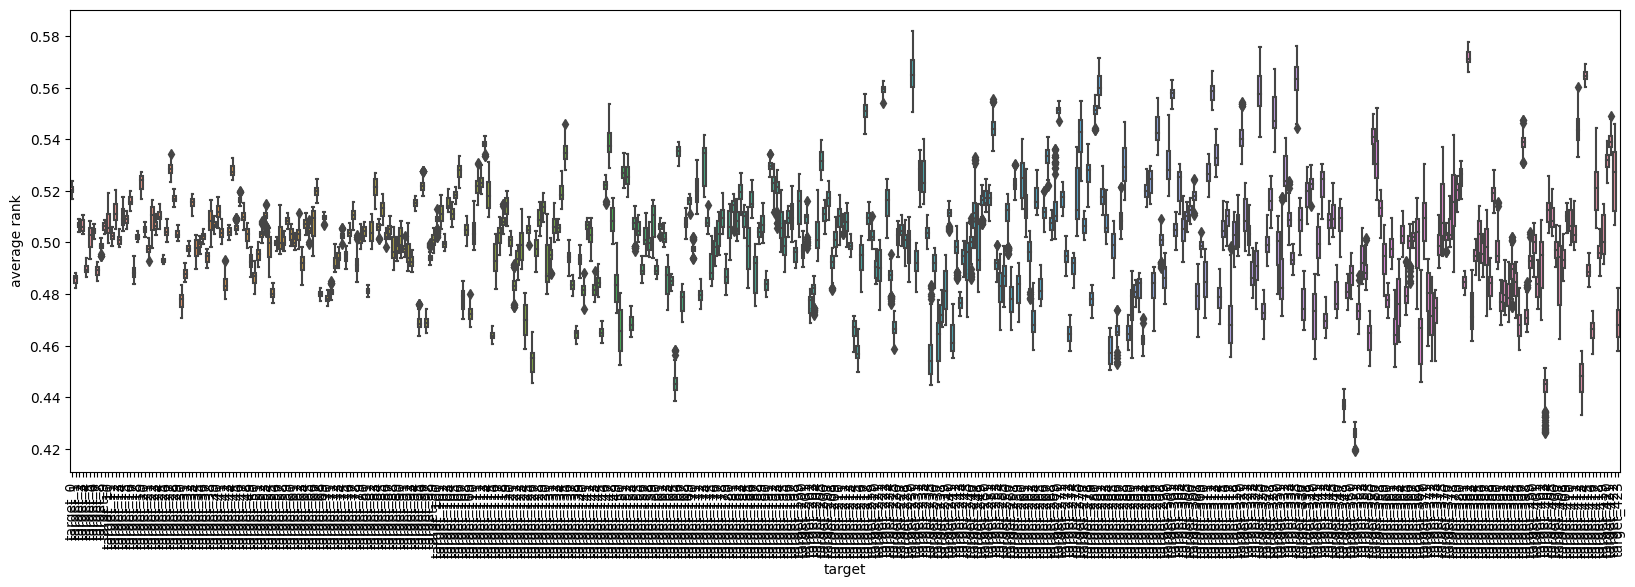

In [10]:
plt.figure(figsize=(20, 6))
sns.boxplot(_df_pred)
_ = plt.xticks(rotation=90)
plt.xlabel('target')
plt.ylabel('average rank')

In [11]:
SOLUTION_NULL_FILLER = -999999


def kgl_rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    """
    Calculates the rank correlation between predictions and target values,
    and returns its Sharpe ratio (mean / standard deviation).

    :param merged_df: DataFrame containing prediction columns (starting with 'prediction_')
                      and target columns (starting with 'target_')
    :return: Sharpe ratio of the rank correlation
    :raises ZeroDivisionError: If the standard deviation is zero
    """
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]

    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            raise ValueError('No non-null target values found')
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            raise ZeroDivisionError('Denominator is zero, unable to compute rank correlation.')
        return np.corrcoef(row[matching_predictions].rank(method='average'), row[non_null_targets].rank(method='average'))[0, 1]

    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    std_dev = daily_rank_corrs.std(ddof=0)
    if std_dev == 0:
        raise ZeroDivisionError('Denominator is zero, unable to compute Sharpe ratio.')
    rank_core_mean = daily_rank_corrs.mean()
    sharpe_ratio = rank_core_mean / std_dev
    return float(sharpe_ratio), rank_core_mean, std_dev


# def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
def kgl_score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    """
    Calculates the rank correlation between predictions and target values,
    and returns its Sharpe ratio (mean / standard deviation).
    """
    # del solution[row_id_column_name]
    # del submission[row_id_column_name]
    assert all(solution.columns == submission.columns)

    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})

    # Not all securities trade on all dates, but solution files cannot contain nulls.
    # The filler value allows us to handle trading halts, holidays, & delistings.
    solution = solution.replace(SOLUTION_NULL_FILLER, None)
    return kgl_rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

In [12]:
# (RankIC Sharpe, RankIC mean, RankIC std)
print('public LB score (first 90 days only) : ', kgl_score(df_train_labels.loc[_df_pred.index].iloc[:90], _df_pred.iloc[:90]))  # pubic LB
print('first 90 days + extended data score : ', kgl_score(df_train_labels.loc[_df_pred.index], _df_pred))
print('extended data only score : ', kgl_score(df_train_labels.loc[_df_pred.index].iloc[90:], _df_pred.iloc[90:]))

public LB score (first 90 days only) :  (0.2543529319372721, 0.06189327032840158, 0.24333617803024005)
first 90 days + extended data score :  (0.22304106140992572, 0.050887127273631746, 0.22815138590157005)
extended data only score :  (0.14820661047865658, 0.028374561934329797, 0.19145274183580396)


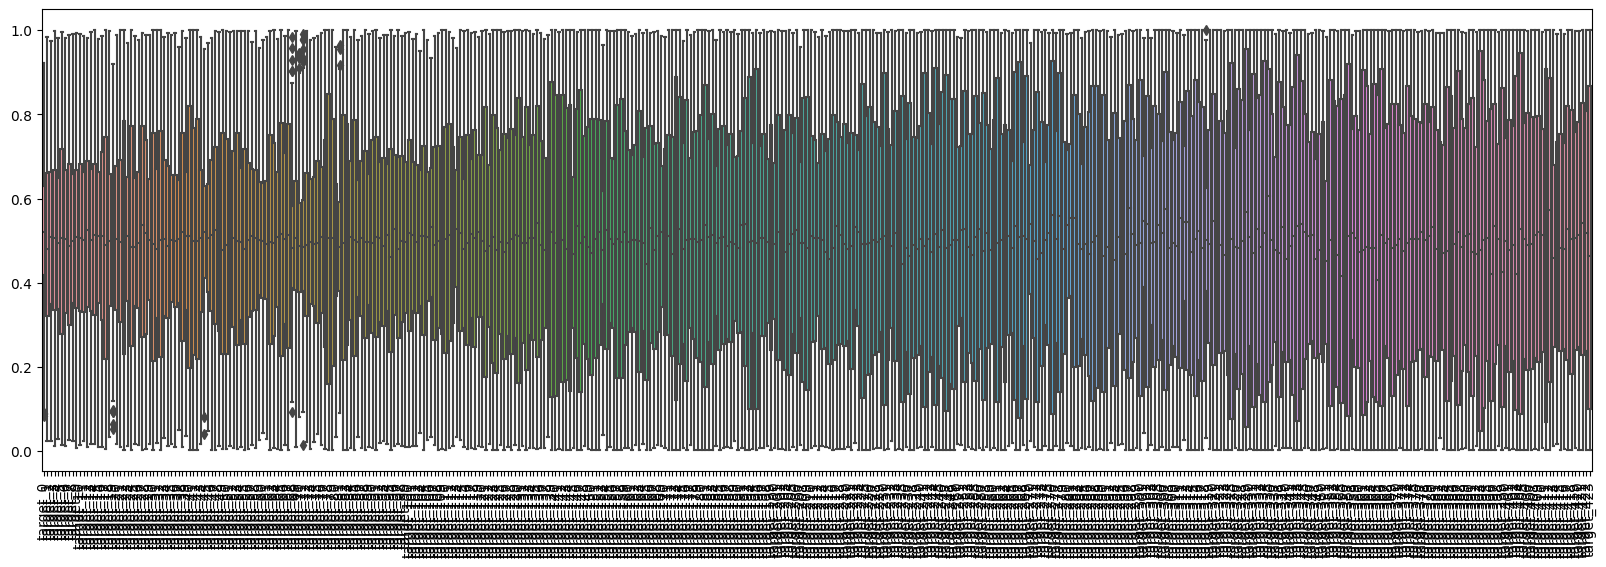

In [13]:
plt.figure(figsize=(20, 6))
sns.boxplot(df_train_labels.rank(axis=1, pct=True))
_ = plt.xticks(rotation=90) 